# ECC
先推薦一些不錯的教材:[1](http://andrea.corbellini.name/tag/ecc/),[2](https://engineering.purdue.edu/kak/compsec/NewLectures/Lecture14.pdf),[3](https://blog.cloudflare.com/a-relatively-easy-to-understand-primer-on-elliptic-curve-cryptography/),[4](https://jeremykun.com/category/cryptography/page/2/)

跟RSA一樣同樣用 elliptic curves, 通常我們可以做以下兩件事:

- Digital signatures (public key equivalent of message authentication codes) Alice 用 private key 簽署, 然後其他人用 public key 驗證
- Encryption with elliptic curves: 通常用來作金鑰交換， Alice 用 elliptic curve Diffie-Hellman (ECDH) 來產生跟Bob的 shared key

## Standard Curve

除了[certicom](https://www.certicom.com/)外，IEEE1363和NIST方面有定義出一些建議使用的curve，其中NIST三條標準的 elliptic curve 為:

- NIST P256 curve, which is equivalent to an AES-128 key (also known as secp256r1)
- NIST P384 curve, which is equivalent to an AES-192 key (also known as secp384r1)
- NIST P521 curve, which is equivalent to an AES-256 key (also known as secp521r1)

另外還有其他著名的curve像是 Curve25519 curve (key exchange使用)，Ed25519 curve (數位簽章使用)，更多curve 選擇[可參考](http://safecurves.cr.yp.to/)

> 這篇文章講到最近密碼系統的現象：「On the Impending Crypto Monoculture」https://blog.gslin.org/archives/2016/03/28/6459/%E5%AF%86%E7%A2%BC%E7%B3%BB%E7%B5%B1%E7%9A%84-monoculture/

> 目前常在用的密碼系統包括了 RSA、DH、ECDH、ECDSA、SHA-2、AES 這些演算法，而最近這幾年大家在推廣使用的演算法都出自於同一個人手裡，Dan Bernstein，也就是 djb： A major feature of these changes includes the dropping of traditional encryption algorithms and mechanisms like RSA, DH, ECDH/ECDSA, SHA-2, and AES, for a completely different set of mechanisms, including Curve25519 (designed by Dan Bernstein et al), EdDSA (Bernstein and colleagues), Poly1305 (Bernstein again) and ChaCha20 (by, you guessed it, Bernstein).

> 這些演算法或是定義，包括了 Curve25519、EdDSA、Poly1305、ChaCha20。而這篇文章試著說明造成這樣情況的背景以及原因，以及這樣會導致什麼問題。當實際分析時會發現，檯面上沒幾個能用的演算法，而看起來能用的那幾個又有專利 (像是 OCB)，不然就是看起來被 NSA 放了一些說明不了的參數 (像是 P-256 Curve)。然後 djb 弄出來的演算法不只看起來乾淨許多，也直接用數學模型證明安全性。而且他的實作也很理論派，像是還蠻堅持要做到 constant time implementation 以避開各種 side channel attack。就... 理論很強，又很實戰派的一個人啊.....，檯面上真的沒幾隻可以打的贏啊 XD

> 最近也有一個有趣的專案[Million Dollar Curve](http://cryptoexperts.github.io/million-dollar-curve/)，想要用樂透等公開random source來建立第三方可驗證的curve

ECC的 Key Exchange (ECDH) 紀錄在 in NIST publication [800-56Ar2](http://nvlpubs.nist.gov/nistpubs/SpecialPublications/NIST.SP.800-56Ar2.pdf)中

## Mathematics Behind Elliptic Curves

Elliptic curve是什麼呢? 事實上著名的Fermat's Last Theorem便是由elliptic curve解開的(不過是定義於實數域的elliptic curve)，可參考[數學女孩](http://www.books.com.tw/products/0010507212)

> [Wolfram MathWorld](http://mathworld.wolfram.com/EllipticCurve.html)有完整數學上的定義

我們可以把他想成由以下方程式組成的點:

$y^2=x^3+ax+b$

其中 $4a^3+27b^2 \neq 0$ (用來排除 singular curves). 這種形式稱為 Weierstrass normal form for elliptic curves

根據不同的a, b值, elliptic curves 會呈現不同的形狀， 我們在實數上畫出來 elliptic curves 是對稱x軸的!

通常我們會把**無窮遠點**也加入 curve中，我們將它標記為 0

故納入無窮遠點後的橢圓曲線為:

$\{(x,y)∈R^2 | y^2=x^3+ax+b, 4a^3+27b^2 \neq 0\} ∪ \{0\}$， 以下我們簡單的畫出elliptic curve和上面的點加法(後面會進一步介紹)給讀者參考:

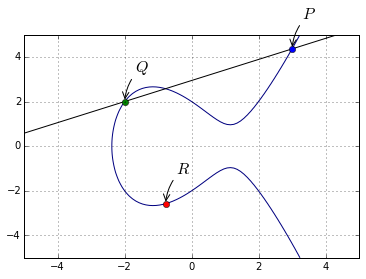

<function __main__.interactive_curve>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from elliptic import *
from fractions import Fraction as frac
import numpy.polynomial.polynomial as poly

def drawLine2P(x,y,xlims):
    xrange = np.arange(xlims[0],xlims[1],0.1)
    A = np.vstack([x, np.ones(len(x))]).T
    k, b = np.linalg.lstsq(A, y)[0]
    plt.plot(xrange, k*xrange + b, 'k')

def interactive_curve(a=-4, b=4, Px=3, Qx=-2):
    if 4*a^3 + 27*b^2 == 0:
        print 'The choice of a = %s and b = %s does not define an elliptic curve because this makes 27a^3 + 4b^2 = 0.'%(a,b)
    else:
        y, x = np.ogrid[-5:5:100j, -5:5:100j]
        plt.contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3) - x * a - b, [0])
        C = EllipticCurve(a=frac(a), b=frac(b))
        ro = poly.polyroots((b,a,0,1))
        ro = ro[np.isreal(ro)]
        if(len(ro) == 1):
            if Px < ro[0].real:
                Px = ro[0].real
            if Qx < ro[0].real:
                Qx = ro[0].real
        else:
            if ro[1].real < Px < ro[2].real:
                Px = ro[1].real
        P = C.from_x(frac(Px))
        Q = C.from_x(frac(Qx))
        R =  P + Q
        zero = Ideal(C)
        drawLine2P([float(P[0]),float(Q[0])],[float(P[1]),float(Q[1])],[-5,5])
        plt.plot(float(P[0]),float(P[1]), 'o')
        plt.plot(float(Q[0]),float(Q[1]), 'o')
        plt.plot(float(R[0]),float(R[1]), 'o')
        plt.xlim([-5,5])
        plt.ylim([-5,5])
        plt.annotate(r'$P$',
             xy=(float(P[0]), float(P[1])), xycoords='data',
             xytext=(+10, +30), textcoords='offset points', fontsize=16,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
        plt.annotate(r'$Q$',
             xy=(float(Q[0]), float(Q[1])), xycoords='data',
             xytext=(+10, +30), textcoords='offset points', fontsize=16,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
        plt.annotate(r'$R$',
             xy=(float(R[0]), float(R[1])), xycoords='data',
             xytext=(+10, +30), textcoords='offset points', fontsize=16,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

        plt.grid()
        plt.show()

from IPython.html.widgets import interact
interact(interactive_curve, a=[-10, 3], b=[-10,10], Px=[-20,20], Qx=[-20, 20])

### Group
我們這邊簡單介紹一些abstract algebra中的群論：一個set我們定義 "addition" 並標示為 +， 此 set G 稱之為 group, addition 必續根據下列四個性質來定義!

1. Closure: 若$a,b$在$G$內, 則$a+b$也要在 $G$內
2. Associativity: $(a+b)+c=a+(b+c)$
3. 有 identity element $0$ 使得 $a+0=0+a=a$
4. 所有元素有 inverse, 亦即對任意 $a$ 一定找的到 $b$ 使得 $a+b=0$

>若再加上 commutativity: $a+b=b+a$ 則此 group 稱為 abelian group.

我們常見的加法配上 integer numbers 組成的set $Z$ 便是 group (事實上他是 abelian group).然而自然數$N$就不是了，因為不符合第四個條件。

若我們能證明某一set滿足以上性質，我們就可以借用抽象代數中的群的相關特性!! 例如: identity element是唯一的，inverse也是唯一的

### Group Law of Elliptic Curve
#### Geometric addition

我們可以定義橢圓曲線群如下:

1. Group 中的元素是 elliptic curve上的點
2. Identity element 是無窮遠點 0;
3. 橢圓曲線上點 P 的 inverse 是對 x 軸鏡射的點

Addition定義為: 給定三個 aligned 且 non-zero 的點 P, Q, R, P+Q+R=0
![](http://andrea.corbellini.name/images/three-aligned-points.png)

經由這樣的定義我們可以得知這個點是無順序性不相關的，也就是說假設 P, Q, R 是 aligned, 則 P+(Q+R)=Q+(P+R)=R+(P+Q)=⋯=0. 因此我們的 ``+`` operator 是 associative 且 commutative 故為一個 abelian group! 既然在abelian group我們就可以把 P+Q+R=0 寫成 P+Q=-R 因此得到圖像加法如下:
![](http://andrea.corbellini.name/images/point-addition.png)

> 可以由[此](https://cdn.rawgit.com/andreacorbellini/ecc/920b29a/interactive/reals-add.html)來感受加法!!

#### Algebraic addition
接下來我們把上述加法寫成數學式，考慮兩個點$P=(x_P,y_P), Q=(x_Q,y_Q)$，假設兩者不同，通過兩點的線斜率為

$m = \frac{y_P - y_Q}{x_P - x_Q}$

而他與橢圓曲線的交點為$R = (x_R, y_R)$

$\begin{array}{rcl}
    x_R & = & m^2 - x_P - x_Q \\
    y_R & = & y_P + m(x_R - x_P)
\end{array}$

因此$(x_P, y_P) + (x_Q, y_Q) = (x_R, -y_R)$

> 若$P=Q$的話，經由微分$y_P = \pm \sqrt{x_P^3 + ax_P + b}$ 可得 $m = \frac{3 x_P^2 + a}{2 y_P}$

### Scalar Multiplication
連加$n$次$P$可寫成$nP$此運算稱為scalar multiplication。
> [這邊](https://cdn.rawgit.com/andreacorbellini/ecc/920b29a/interactive/reals-mul.html)可感受乘法

在實際時做上，我們可以藉由double-and-add來加速此運算

```
def bits(n):
    """
    Generates the binary digits of n, starting
    from the least significant bit.

    bits(151) -> 1, 1, 1, 0, 1, 0, 0, 1
    """
    while n:
        yield n & 1
        n >>= 1

def double_and_add(n, x):
    """
    Returns the result of n * x, computed using
    the double and add algorithm.
    """
    result = 0
    addend = x

    for bit in bits(n):
        if bit == 1:
            result += addend
        addend *= 2

    return result
```

### Logarithm
橢圓曲線基於的數學問題是elliptic curve discret logarithm problem(ECDLP): 給定$n, P$我們可以很快利用上述方法算出$Q=nP$，然而給$Q$和$P$要推$n$就不容易了...。

### Finite Field
實數域的elliptic curve並不能拿來密碼學使用(前述是在實數中)，這邊我們介紹Galois Field (Finite Field)。 Finite field 是一個元素為有限數目的set， 一個簡單的例子是 integers modulo p ($p$為質數)。 我們通常寫成 $Z/p, GF(p), F_p$. 

在 field 中我們有兩種 binary operations: addition (+) 和 multiplication (·)， 兩者皆為 closed, associative 且 commutative。對此兩種運算, 都存在著唯一的identity element， 且對field內的 element 都有唯一的 inverse element。 最後 multiplicationy在field中是 distributive over addition: $x⋅(y+z)=x⋅y+x⋅z$

> $x/y$在field中可寫成$x*y^{-1}$，

## EC over Finite Field
接下來我們將elliptic curve限制在 Finit Field中 (注意其仍為abelian group!)

$
\begin{array}{rcl}
  \left\{(x, y) \in (\mathbb{F}_p)^2 \right. & \left. | \right. & \left. y^2 \equiv x^3 + ax + b \pmod{p}, \right. \\
  & & \left. 4a^3 + 27b^2 \not\equiv 0 \pmod{p}\right\}\ \cup\ \left\{0\right\}
\end{array}
$

0 為無窮遠點, 且 a 和 b 為兩個 $F_p$中的 integer.

來感受一下現在他長怎麼樣吧( $y^2 \equiv x^3 - 7x + 10 \pmod{p}$ 當 $p=19,97,127,487$ 對每一x最多會有兩點y。 另外點是對 $y=p/2$ 對稱的!)

![](http://andrea.corbellini.name/images/elliptic-curves-mod-p.png)

經過此一限制之後，geometric addition會變得不太一樣(可以玩前述tool)，不過我們保持定義的話，algebra addition仍然可保持相同公式(多了modulus P)。

接下來我們可以證明出 multiples of P 實際上是一個 ``cyclic subgroup of the group formed by the elliptic curve``，藉此我們進一步定義出elliptic curve的order(所有點的數目)和點的order(加幾次可以回到自己)。

## Elliptic Curve for Cryptography
對密碼學應用來說，我們會去選擇高order的 subgroups。 實務上我們會先選 elliptic curve, 然後計算 order (N), 選擇 high divisor的(n) 來當 subgroup order， 最後找到適合的 base point。

Lagrange's theorem 告訴我們 $h=N/n$ 永遠是整數 (因為 $n$ 為 $N$的 divisor). $h$ 稱作 cofactor of the subgroup.

假設 $E$ 為定義在 field $K$ 上的 elliptic curve，根據 group addition law 我們可以知道每一個$E$上的點都可以產生出一個 cyclic group $G$。若這個 $G$ 的 order 是質數的話就可以用在cryptography上。

> 這表示group operation, inversion, hasing都可以很快完成，但是DLP很難解

因此跟$F^*$乘法群的對照便是**我們可以用$E(K)$上的點配上點加法來類比乘法群元素**。在乘法群中，我們會選擇一個$F^*$的subgroup $G$ order為$n$，但任意選通常不會有此order，因此常見的做法是用演算法隨機hash到一個 $x \in F^*$，然後再把他exponential 成 $N/n$，($N$為 $F^*$的元素數量)。

橢圓曲線也是如此，假設$N = \#E(K)$，

  - 選一個curve $E(K)$，計算他的 order N
  - 選一個prime $n$整除$N$，但是$n^2$不能整除$N$， 來建立出 order 為 $n$的 subgroup。並計算 cofactor $h=N/n$
  - 選擇隨機點 $P$，然後計算 $G=hP$ (hashing也是如此做)
  - 接下來group operation用addition，negate去反轉$y$做標，點乘法用point multiplication。

若 $G$ 為 $O$, 回到 step 3. 最後我們得到 subgroup with order $n$ 和 cofactor $h$.


### Domain Parameter
Elliptic curve algorithms 是定義於 **cyclic subgroup of an elliptic curve over a finite field** 因此我們會有下列參數:

- The prime $p$ that specifies the size of the finite field.
- The coefficients $a$ and $b$ of the elliptic curve equation.
- The base point $G$ that generates our subgroup.
- The order $n$ of the subgrouop.
- The cofactor $h$ of the subgroup.

也就是 domain parameters包含tuple $(p,a,b,G,n,h)$

事實上有些curve是不安全的，我們如何確保選出的curve是安全的呢，有一種常見作法如下
![](http://andrea.corbellini.name/images/random-parameters-generation.png)

> Curve 用此方法產生稱作 verifiably random. 這個用 hashes 產生 parameters 的方法叫 "nothing up my sleeve", 常常被用於 cryptography中

他給我們一些信心，curve不會是 crafted 而有特定 vulnerabilities 只有設計者知道。 事實上設計者給我們seed和curve， 他沒辦法控制我們選取 parameters $a$ 和 $b$， 因此比較有安全感。

> 標準產生和驗證 random curves 的方法訂於 ANSI X9.62 並用到 SHA-1. 可以看[SECG](http://www.secg.org/sec1-v2.pdf)的相關說明

可以用以下程式來確認:

In [2]:
%%bash
python3 verifyrandom.py

prime192v1: ok
prime192v2: ok
prime192v3: ok
prime239v1: ok
prime239v2: ok
prime239v3: ok
prime256v1: ok
secp112r1: ok
secp112r2: ok
secp128r1: ok
secp128r2: ok
secp160r1: ok
secp160r2: ok
secp224r1: ok
secp384r1: ok
secp521r1: ok
wrong192v1: failed
wrong192v2: failed
wrong192v3: failed
wrong192v4: failed


## ECC

- Private key 為在$\{1,…,n−1\}$之間的 random integer $d$ ($n$ 為 subgroup 的order).
- Public key 為 $H=dG$ 這個point ($G$ 為 subgroup的base point).

接下來我們將重點放在 ECDH (Elliptic curve Diffie-Hellman)(用於加密), 和 ECDSA (Elliptic Curve Digital Signature Algorithm)(用於簽章)

In [3]:
%%bash
python3 ecdhe.py

Curve: secp256k1
Alice's private key: 0xfe87acc1df5d3e122da8818d34a4d6627b38d9a563fc407fff15a232575f5ec1
Alice's public key: (0xd14173fd42abcc2afae88de724c03b2ffd263236d7449c5bdf9a7814804094ee, 0x61f9604e3bdc276bafcbe0bbc88a791ef58a0942b7a109f3cead5641f6b54b41)
Bob's private key: 0x90d1ed12fb4df83d0eb733527cc34830a6ad8d8fa2f29cafd9c30385922ff80d
Bob's public key: (0xf8732340a6795a006d036b21cb19117733a279e4121d0b45cc2b21ca9c022052, 0x819d30959eb3b726e834ec650b266c243ac11d0479a09a7c3e23fca774f8d969)
Shared secret: (0xbed0955dd53e27578e53d1f23e950e1241b7160d50dcc328308dbaa65f32da92, 0x6912aa2503a8c5d4d3bbf42e2819816b1c259a427830a92f4256ebc163de31ec)


In [4]:
%%bash
python3 ecdsa.py

Curve: secp256k1
Private key: 0x9a15596a2a3c2d4b1f25715a9724d09ec7741a20681bf8af3f3ec6260fdb2e3f
Public key: (0x59c38faead652e20cd34bc9b723919ef27143ac9efdc1374266e260c77d0f332, 0xae2d13aee73a28f4cfca2c36e2ca0b569d8f4685d082f09c9e01d2ff4c2125c0)

Message: b'Hello!'
Signature: (0xc22e373ddcd1863f8a08ef2ddfb28224108aa623c5da1017e3d44c8c869ec414, 0xe9cf2d0fe54fe1e4528b5f9a63d9201e59d7113aff5c4660f6364f6f46ba47ce)
Verification: signature matches

Message: b'Hi there!'
Verification: invalid signature

Message: b'Hello!'
Public key: (0x7fef30696cb1d9d905c564e80212c55260471d5355a1bbb444ebae80f685e4c2, 0xc2d39bdec913e70cdc7273b89224d8388ee3907fa6e2c8e8ec68bafbee308b01)
Verification: invalid signature


> 最後，我們上述都是在prime filed, affine coordinate, Weierstrass form curve，更多的其他選擇和加法公式可參考 [EFD](https://hyperelliptic.org/EFD/)

## Pyelliptic
在這邊我們先使用 PyElliptic 這個提供 ECC class 的library，來實際應用在金鑰交換以及數位簽章上

### Generating Keys

假設我們AES用256 bit, 所以這邊至少要用到 P521的curve

In [5]:
import pyelliptic
def generate_key():
     return pyelliptic.ECC(curve='secp521r1')

Public 和 private keys 可以從curve exported 出來

In [6]:
curve = generate_key()
priv = curve.get_privkey()
pub = curve.get_pubkey()
print curve.get_curve()
print priv.encode('hex'), len(priv.encode('hex')), len(priv)
print pub.encode('hex'), len(pub.encode('hex')), len(pub)

secp521r1
011daa58782f1da37bb392ea5e715bea15f3e15330368ad01303d9f95e4a5753d999bb2bad0342f229056d3ccc245310180f0f1ceadd60b1d336b81b3f74fe0fab53 132 66
0401032e7dbd63c1fe986626e2710d01b247e835aa7b5e9c1258449bbdaa371bc44df1e034d91735f63894ac4f97abe3f86e55fb1ed0283ff27309e47cb5dd61a0c4ac01035ac5ea33ff53b062a1a94e3dc2c6c906350bf1d719b6e883df66e2e564c6c27fa75eace5feaebb950d1c4d7f281933faccdf7d8b00dddd9c4c4ed4e1a4099dc3 266 133


### Signing Messages

通常做數位簽章的時候， 我們會先計算 message 的 hash 再做簽章。 PyElliptic 會使用 SHA-512 來做 ECDSA.

In [7]:
def sign(key, msg):
    """Sign a message with the ECDSA key."""
    return key.sign(msg)

驗證時候的input是 serialised public key 然後匯入 pyelliptic.ecc.ECC instance 做運算

In [8]:
def verify(pub, msg, sig):
    """Verify the signature on a message."""
    return pyelliptic.ECC(curve='secp521r1', pubkey=pub).verify(sig, msg)

### Encryption

現在來說明如何用ECDH來產生shared key

用 pyelliptic時， private key 要是 instance of pyelliptic.ecc.ECC; 而 public key 要是 serialised form.

In [9]:
shared_key = curve.get_ecdh_key(pub)
len(shared_key)

32

In [10]:
def shared_key(curve, pub):
    """Generate a new shared encryption key from a keypair."""
    shared_key = curve.get_ecdh_key(pub)
    return shared_key

### Ephemeral keys

接下來我們來看看常見的 hybrid encryption的方式，我們會用 ephemeral keys 來做 encryption;也就是我們每次加密會產生 elliptic curve key pair 這種加密方法叫 elliptic curve integrated encryption scheme,  ECIES。 (或更準確來說，因為 key exchange 為 on the fly 完成，故稱為 ECDHE)

In [11]:
import struct
import Crypto.Random.OSRNG.posix as RNG
import Crypto.Cipher.AES as AES 
__AES_KEYLEN = 32

def generate_nonce():
    """Generate a random number used once."""
    return RNG.new().read(AES.block_size)

def pad_data(data):
    """pad_data pads out the data to an AES block length."""
    # return data if no padding is required
    if len(data) % 16 == 0:
        return data

    # subtract one byte that should be the 0x80
    # if 0 bytes of padding are required, it means only
    # a single \x80 is required.

    padding_required = 15 - (len(data) % 16)

    data = '%s\x80' % data
    data = '%s%s' % (data, '\x00' * padding_required)

    return data

def unpad_data(data):
    """unpad_data removes padding from the data."""
    if not data:
        return data

    data = data.rstrip('\x00')
    if data[-1] == '\x80':
        return data[:-1]
    else:
        return data

def sym_encrypt(data, key):
     """
     Encrypt data using AES in CBC mode. The IV is prepended to the
     ciphertext.
     """
     data = pad_data(data)
     ivec = generate_nonce()
     aes = AES.new(key, AES.MODE_CBC, ivec)
     ctxt = aes.encrypt(data)
     return ivec + ctxt
 
 
def sym_decrypt(ciphertext, key):
     """
     Decrypt a ciphertext encrypted with AES in CBC mode; assumes the IV
     has been prepended to the ciphertext.
     """
     if len(ciphertext) <= AES.block_size:
         raise Exception("Invalid ciphertext.")
     ivec = ciphertext[:AES.block_size]
     ciphertext = ciphertext[AES.block_size:]
     aes = AES.new(key, AES.MODE_CBC, ivec)
     data = aes.decrypt(ciphertext)
     return unpad_data(data)


def encrypt(pub, msg):
    """
    Encrypt the message to the public key using ECIES. The public key
    should be a serialised public key.
    """
    ephemeral = generate_key() # Alice's private key
    key = shared_key(ephemeral, pub) #Symmetric key derives from ECDH (alice_priv + bob_pub)
    ephemeral_pub = struct.pack('>H', len(ephemeral.get_pubkey()))
    print ephemeral_pub, len(ephemeral.get_pubkey())
    ephemeral_pub += ephemeral.get_pubkey() # Alice's public key
    print ephemeral_pub
    return ephemeral_pub + sym_encrypt(msg, key)

def decrypt(priv, msg):
    """
    Decrypt an ECIES-encrypted message with the private key.
    """
    ephemeral_len = struct.unpack('>H', msg[:2])[0]
    ephemeral_pub = msg[2:2+ephemeral_len] # Alice's public key
    key = shared_key(priv, ephemeral_pub) #symmetric key derives from ECDH(bob_priv, alice_pub)
    return sym_decrypt(msg[2+ephemeral_len:], key)

上述我們將 public key 加到開頭， 包含 public key 的長度，然後將 ciphertext 接在後面。 解密時需要解回 public key (先讀取 length 然後從  message 中擷取出 public key) 接著用ECDH 找出 shared key後進行訊息加密

In [12]:
curve = generate_key() # Bob generate private key
pub  = curve.get_pubkey() # Alice get the pubkey from Bob
plaintext = 'AG is god'
ciphertext = encrypt(pub, plaintext) # Alice encrypt message
print decrypt(curve, ciphertext) #Bob decrypt it

 � 133
 �Y�I�J	���T��d�0x`l:����@j��aԬ��M�{�K�m��'��CȘ�|N�o�!n#
�-� s,�w�t���I<5k ����h�jh�'�K��J���^��4��55��
8��8F�����
AG is god


### Key Exchange

那麼 Alice 要如何得知public key是真的屬於Bob的呢? 認證方法有兩種: centralised and decentralised. 

TLS/SSL用的是 centralised 的方法: root certificate1 authority (CA) 簽署 intermediary CA 的 key, 然後intermediate CA 再簽署 user keys. 例如 Bob 產生 SSL keypair. 然後接著產生 certificate signing request (CSR) 並送給 CA 要求認證. CA根據不同等級進行收費和認證，最後進行簽署. Bob 將簽署好的 SSL certificate放上webserver， Alice 若相信簽署的CA就會用Bob的 public key，通常 Alice 的 web browser 會有 計載了部分 CA 的 public keys (像是 VeriSigns) 並幫她驗證各個網站的憑證. 這套系統就是 public key infrastructure (PKI)

另一個做法是 PGP 用 decentralised model. 在 PGP 中有一個 Web of Trust (信任網). 例如當 Carol 要傳訊息給 Bob 並把她的 public key給Bob， Bob 會去確認 Carol的 key 是否經過其他人簽署. 例如若　Bob 知道Alice的public key屬於 Alice 且相信她， 而 Alice 曾簽署 Carol’s key. Bob 在其憑證上看到 Alice的 signature 則他對 Carol的信任度就會提高. 接著假設 Dave 的 key 有被 Carol 簽署過, Bob 會對 Dave多一些信心, 但可能沒那麼高，因為他未必相信Carol是合法的簽署者. 基由以上機制，Bob會有 **various trust levels**, 進而形成 web of trust 

接下來看一個完整的例子

In [13]:
import binascii
# Asymmetric encryption
alice = pyelliptic.ECC() # default curve: sect283r1
bob = pyelliptic.ECC(curve='sect571r1')

ciphertext = alice.encrypt("Hello Bob", bob.get_pubkey(),
                           ephemcurve='sect571r1')
print(bob.decrypt(ciphertext))

signature = bob.sign("Hello Alice")
# alice's job :
print(pyelliptic.ECC(pubkey=bob.get_pubkey(),
                     curve='sect571r1').verify(signature, "Hello Alice"))

# ERROR !!!
try:
    key = alice.get_ecdh_key(bob.get_pubkey())
except:
    print("For ECDH key agreement, the keys must be defined on the same curve !")

alice = pyelliptic.ECC(curve='sect571r1')
print(binascii.hexlify(alice.get_ecdh_key(bob.get_pubkey())))
print(binascii.hexlify(bob.get_ecdh_key(alice.get_pubkey())))

Hello Bob
True
For ECDH key agreement, the keys must be defined on the same curve !
04c50c42da4996c0d136176e03129cdfe74cc6e2ccf94de8a19c817006675514
04c50c42da4996c0d136176e03129cdfe74cc6e2ccf94de8a19c817006675514


In [17]:
%reload_ext version_information
%version_information numpy, scipy, matplotlib, pycrypto, pyelliptic, version_information

Software versions
Python 2.7.10 64bit [GCC 5.2.1 20151010]
IPython 5.0.0
OS Linux 4.2.0 30 generic x86_64 with Ubuntu 15.10 wily
numpy 1.8.2
scipy 0.14.1
matplotlib 1.4.2
pycrypto 2.6.1
pyelliptic 1.5.7
version_information 1.0.3
Wed Jul 20 07:14:30 2016 UTC

## Cryptography

我們進一步貼近實務，通常key會經過key derivation function，上述的ECDHE 會比 ECDH更好，因為它提供了 forward secrecy

> 記得對於每次 exchange() 我們需要有對應的  generate_private_key() (ECDHE key exchange)

In [4]:
!pip install cryptography==1.4

Downloading/unpacking cryptography==1.4
  Running setup.py (path:/tmp/pip-build-JOAQBL/cryptography/setup.py) egg_info for package cryptography
    
    no previously-included directories found matching 'docs/_build'
Downloading/unpacking idna>=2.0 (from cryptography==1.4)
Downloading/unpacking pyasn1>=0.1.8 (from cryptography==1.4)
Downloading/unpacking six>=1.4.1 (from cryptography==1.4)
Downloading/unpacking setuptools>=11.3 (from cryptography==1.4)
Downloading/unpacking enum34 (from cryptography==1.4)
Downloading/unpacking ipaddress (from cryptography==1.4)
Downloading/unpacking cffi>=1.4.1 (from cryptography==1.4)
  Running setup.py (path:/tmp/pip-build-JOAQBL/cffi/setup.py) egg_info for package cffi
    
Downloading/unpacking pycparser (from cffi>=1.4.1->cryptography==1.4)
  Running setup.py (path:/tmp/pip-build-JOAQBL/pycparser/setup.py) egg_info for package pycparser
    
  Running setup.py install for cryptography
    
    no previously-included directories found matching 'doc

In [3]:
import sys
from os.path import expanduser
sys.path.insert(0, expanduser('~/.local/lib/python2.7/site-packages/'))

In [4]:
import cryptography
print cryptography
print (cryptography.__version__)

<module 'cryptography' from '/projects/7171577f-a330-4f46-8f6d-303bd01a7bdc/.local/lib/python2.7/site-packages/cryptography/__init__.pyc'>
1.4


In [5]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import ec

message = b"encrypted data"
private_key = ec.generate_private_key(
    ec.SECP384R1(), default_backend()
) # Alice private key
peer_public_key = ec.generate_private_key(
    ec.SECP384R1(), default_backend()
).public_key() # Bob's private key and public key
shared_key = private_key.exchange(ec.ECDH(), peer_public_key)
print (shared_key, len(shared_key))

('\xb0\xfdD\x9b\xdf\xd3\xec\x9a\x86d\xb7\x1b3c-\x16\x99p\xeb\x92\x93\x18\x85\xe2?\xb2I\x80\x10\xef\x81\xbb\xe2*)\xefd\xe1\xb6\x14$\xfb\x15@\xbey\xe8\x07', 48)


簽章看看吧，我們依照[FIPS 186-4](http://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.186-4.pdf) 來簽

``decode_dss_signature()`` 可以解回DER形式儲存的 signature

> 複習一下，PEM 為 encapsulation format,他可以是數種不同的 key types. 另外 PEM keys 是可讀的會有以下形式: -----BEGIN {format}----- ....-----END {format}-----.

> 另一方面，DER 是 ASN.1 encoding type.他不是encapsulation且 data 是 binary

In [6]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives.asymmetric.utils import decode_dss_signature

private_key = ec.generate_private_key(
    ec.SECP384R1(), default_backend()
) # Alice private key
public_key = private_key.public_key() # Alice public key
signer = private_key.signer(ec.ECDSA(hashes.SHA256())) # Specify signing alog. and hash function
message = b"this is some data I'd like to sign"
signer.update(message)
signature = signer.finalize()
print (signature, decode_dss_signature(signature))
verifier = public_key.verifier(signature,ec.ECDSA(hashes.SHA256()))
verifier.update(message)
verifier.verify()

('0e\x020E\xbb8\xda\r?\x03\xed\x91\xb2\xc5>\x8cku\xa4\xfc\xd3J\xae\xfe\x00\xa9OH#\xbaY\xdc\xe2[\x1b\xac\xb1|\\\xd7yv\x05rj@\xe6\x9f\x01N\xd2\x021\x00\xf3\x87|&R\xb4\xaf\x06\xcd\xda\xc6!\xd2\xa8 \x9c\xb3\xda\xfe\xaf\xb8\xe4\xe1p\xa2\xe0\xe4\xfa\x86\xa8\xb3d\xee\xba\x0eA\xe3\xcc4I\x0f\xafk\xd5\xd0s\xda\xfc', (10732634931934614946651172655697691162809083884759133819765412693530184615913104662494149326616520739442363174309586L, 37482580271750377263786983274074406872736715159614656871339724431020335622131783853426372467313188754138993962244860L))


True

## OpenSSL

1) Use Nacl, Ed25519, or RFC6979.

You care about this if: you're designing a new cryptocurrency. Or, a system to sign Ruby Gems or Vagrant images, or a DRM scheme, where the authenticity of a series of files arriving at random times needs to be checked offline against the same secret key. Or, you're designing an encrypted message transport.

The allegations from the previous answer are incorporated herein as if stated in full.

In 10+ years of doing software security assessments I can count on none fingers the number of RSA-PSS users I was paid to look at. RSA-PSS is an academic recommendation.

The two dominating use cases within the last 10 years for asymmetric signatures are cryptocurrencies and forward-secret key agreement, as with ECDHE-TLS. The dominating algorithms for these use cases are all elliptic-curve based. Be wary of new systems that use RSA signatures.

In the last few years there has been a major shift away from conventional DSA signatures and towards misuse-resistent "deterministic" signature schemes, of which EdDSA and RFC6979 are the best examples. You can think of these schemes as "user-proofed" responses to the Playstation 3 ECDSA flaw, in which reuse of a random number leaked secret keys. Use deterministic signatures in preference to any other signature scheme.

Avoid: RSA-PKCS1v15, RSA, ECDSA, DSA; really, especially avoid conventional DSA and ECDSA.




2) Diffie-Hellman (Was: Operate over the 2048-bit Group #14 with a generator of 2): Probably still DH-2048, or Nacl.

You care about this if: you're designing an encrypted transport or messaging system that will be used someday by a stranger, and so static AES keys won't work.

This is the trickiest one. Here is roughly the set of considerations:

If you can just use Nacl, use Nacl. You don't even have to care what Nacl does.
If you can use a very trustworthy library, use Curve25519; it's the modern ECDH curve with the best software support and the most analysis. People really beat the crap out of Curve25519 when they tried to get it standardized for TLS. There are stronger curves, but none supported as well as Curve25519.

But don't implement Curve25519 yourself or port the C code for it.

If you can't use a very trustworthy library for ECDH but can for DH, use DH-2048 with a standard 2048 bit group, like Colin says, but only if you can hardcode the DH parameters.

But don't use conventional DH if you need to negotiate parameters or interoperate with other implementations.
If you have to do handshake negotiation or interoperate with older software, consider using NIST P-256, which has very widespread software support. Hardcoded-param DH-2048 is safer than NIST P-256, but NIST P-256 is safer than negotiated DH. But only if you have very trustworthy library support, because NIST P-256 has some pitfalls. P-256 is probably the safest of the NIST curves; don't go down to -224. Isn't crypto fun?

If your threat model is criminals, prefer DH-1024 to sketchy curve libraries. If your threat model is governments, prefer sketchy curve libraries to DH-1024. But come on, find a way to one of the previous recommendations.
It sucks that DH (really, "key agreement") is such an important crypto building block, but it is.

Avoid: conventional DH, SRP, J-PAKE, handshakes and negotiation, elaborate key negotiation schemes that only use block ciphers, srand(time()).



3) Website security (Was: Use OpenSSL.): Remains: OpenSSL, or BoringSSL if you can. Or just use AWS ELBs.

You care about this if: you have a website.

By "website security", Colin means "the library you use to make your web server speak HTTPS". Believe it or not, OpenSSL is still probably the right decision here, if you can't just delegate this to Amazon and use HTTPS elastic load balancers, which makes this their problem not yours.

Avoid: offbeat TLS libraries like PolarSSL, GnuTLS, and MatrixSSL.

4) Client-server application security (Was: ship RSA keys and do custom RSA protocol) Use TLS.

You care about this if: the previous recommendations about public-key crypto were relevant to you.

What happens when you design your own custom RSA protocol is that 1-18 months afterwards, hopefully sooner but often later, you discover that you made a mistake and your protocol had virtually no security. That happened to Colin, but a better example is Salt Stack. Salt managed to deploy e=1 RSA.

It seems a little crazy to recommend TLS given its recent history:

The Logjam DH negotiation attack
The FREAK export cipher attack
The POODLE CBC oracle attack
The RC4 fiasco
The CRIME compression attack
The Lucky13 CBC padding oracle timing attack
The BEAST CBC chained IV attack
Heartbleed
Renegotiation
Triple Handshakes
Compromised CAs
Here's why you should still use TLS for your custom transport problem:

Many of these attacks only work against browsers, because they rely on the victim accepting and executing attacker-controlled Javascript in order to generate repeated known/chosen plaintexts.
Most of these attacks can be mitigated by hardcoding TLS 1.2+, ECDHE and AES-GCM. That sounds tricky, and it is, but it's less tricky than designing your own transport protocol with ECDHE and AES-GCM!
In a custom transport scenario, you don't need to depend on CAs: you can self-sign a certificate and ship it with your code, just like Colin suggests you do with RSA keys.
Avoid: designing your own encrypted transport, which is a genuinely hard engineering problem; using TLS but in a default configuration, like, with "curl"; using "curl", IPSEC.

5) Online backups (Was: Use Tarsnap): Remains Tarsnap.


In [7]:
%%bash
openssl ecparam -list_curves

  secp112r1 : SECG/WTLS curve over a 112 bit prime field
  secp112r2 : SECG curve over a 112 bit prime field
  secp128r1 : SECG curve over a 128 bit prime field
  secp128r2 : SECG curve over a 128 bit prime field
  secp160k1 : SECG curve over a 160 bit prime field
  secp160r1 : SECG curve over a 160 bit prime field
  secp160r2 : SECG/WTLS curve over a 160 bit prime field
  secp192k1 : SECG curve over a 192 bit prime field
  secp224k1 : SECG curve over a 224 bit prime field
  secp224r1 : NIST/SECG curve over a 224 bit prime field
  secp256k1 : SECG curve over a 256 bit prime field
  secp384r1 : NIST/SECG curve over a 384 bit prime field
  secp521r1 : NIST/SECG curve over a 521 bit prime field
  prime192v1: NIST/X9.62/SECG curve over a 192 bit prime field
  prime192v2: X9.62 curve over a 192 bit prime field
  prime192v3: X9.62 curve over a 192 bit prime field
  prime239v1: X9.62 curve over a 239 bit prime field
  prime239v2: X9.62 curve over a 239 bit prime field
  prime239v3: X9.62 curv

In [8]:
%%bash
openssl ecparam -param_enc explicit -conv_form uncompressed -text -noout -no_seed -name secp112r1

Field Type: prime-field
Prime:
    00:db:7c:2a:bf:62:e3:5e:66:80:76:be:ad:20:8b
A:   
    00:db:7c:2a:bf:62:e3:5e:66:80:76:be:ad:20:88
B:   
    65:9e:f8:ba:04:39:16:ee:de:89:11:70:2b:22
Generator (uncompressed):
    04:09:48:72:39:99:5a:5e:e7:6b:55:f9:c2:f0:98:
    a8:9c:e5:af:87:24:c0:a2:3e:0e:0f:f7:75:00
Order: 
    00:db:7c:2a:bf:62:e3:5e:76:28:df:ac:65:61:c5
Cofactor:  1 (0x1)


> 6-4 sony ps3的 attack

## Discrte Logarithm Problem
給定橢圓曲線上兩點 $P$ 和 $Q$ 試著找出滿足 $Q=xP$ 的整數$x$。 記得這些點為 elliptic curve的一個subgroup， base point 為 $G$，而$G$的order 為 $n$。

### Baby-step, giant-step
我們可以把一個整數 $x$ 寫成 $x=am+b$，其中 $a, m, b$ 皆為任意的整數。 例如我們可以把 $10$ 寫成 $2⋅3+4$

同理我們可以把 discrete logarithm problem 寫成：

$
Q=xP
$

$
Q=(am+b)P
$

$
Q=amP+bP
$

$
Q−amP=bP
$

Baby-step giant-step 的想法是 "meet in the middle"。 和 brute-force attack 不一樣的地方是，攻擊者先計算 "一些" $bP$ 的數值和 "一些" $Q−amP$ 的數值直到它們相等，如下所示:

1.計算 $m=\lceil\sqrt n\rceil $

2.對於每一個在 $0,...,m$ 的 $b$ 計算 $bP$ 然後將它存入 hash table。

3.對於每一個在 $0,...,m$ 的 $a$

    1. 計算$amP$
    
    1. 計算 $Q−amP$
    
    1. 尋找 hash table 中是否存在一個點 $bP$ 使得 $Q−amP=bP$
    
    1. 若存在我們回傳 $x=am+b$

In [10]:
%reload_ext version_information
%version_information numpy, scipy, matplotlib, pycrypto, cryptography, pyopenssl, pyelliptic, version_information

Software,Version
Python,2.7.10 64bit [GCC 5.2.1 20151010]
IPython,5.0.0
OS,Linux 4.2.0 30 generic x86_64 with Ubuntu 15.10 wily
numpy,1.8.2
scipy,0.14.1
matplotlib,1.4.2
pycrypto,2.6.1
cryptography,1.4
pyopenssl,0.15.1
pyelliptic,1.5.7


## Post quantum
Google:
https://security.googleblog.com/2016/07/experimenting-with-post-quantum.html